## 3.6 预测房价：回归问题
前面两个例子都是分类问题，其目标是预测输入数据点所对应的单一离散的标签。另一种常见的机器学习问题是回归问题，它预测一个连续值而不是离散的标签，例如，根据气象数据预测明天的气温，或者根据软件说明书预测完成软件项目所需要的时间。

本节将要预测20 世纪70 年代中期波士顿郊区房屋价格的中位数，已知当时郊区的一些数据点，比如犯罪率、当地房产税率等。本节用到的数据集与前面两个例子有一个有趣的区别。它包含的数据点相对较少，只有506 个，分为404 个训练样本和102 个测试样本。输入数据的每个特征（比如犯罪率）都有不同的取值范围。例如，有些特性是比例，取值范围为0~1；有的取值范围为1~12；还有的取值范围为0~100，等等。

加载波士顿房价数据

In [15]:
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [16]:
train_data.shape

(404, 13)

In [17]:
test_data.shape

(102, 13)

In [18]:
# 目标是房屋价格的中位数，单位是千美元
train_targets[:5]

array([15.2, 42.3, 50. , 21.1, 17.7])

### 准备数据
将取值范围差异很大的数据输入到神经网络中，这是有问题的。网络可能会自动适应这种取值范围不同的数据，但学习肯定变得更加困难。对于这种数据，普遍采用的最佳实践是对每个特征做标准化，即对于输入数据的每个特征（输入数据矩阵中的列），减去特征平均值，再除以标准差，这样得到的特征平均值为0，标准差为1。用Numpy 可以很容易实现标准化。

#### 数据标准化

In [19]:
mean = train_data.mean(axis=0)
mean

array([3.74511057e+00, 1.14801980e+01, 1.11044307e+01, 6.18811881e-02,
       5.57355941e-01, 6.26708168e+00, 6.90106436e+01, 3.74027079e+00,
       9.44059406e+00, 4.05898515e+02, 1.84759901e+01, 3.54783168e+02,
       1.27408168e+01])

In [20]:
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

In [21]:
train_data

array([[-0.27224633, -0.48361547, -0.43576161, ...,  1.14850044,
         0.44807713,  0.8252202 ],
       [-0.40342651,  2.99178419, -1.33391162, ..., -1.71818909,
         0.43190599, -1.32920239],
       [ 0.1249402 , -0.48361547,  1.0283258 , ...,  0.78447637,
         0.22061726, -1.30850006],
       ...,
       [-0.40202987,  0.99079651, -0.7415148 , ..., -0.71712291,
         0.07943894, -0.67776904],
       [-0.17292018, -0.48361547,  1.24588095, ..., -1.71818909,
        -0.98764362,  0.42083466],
       [-0.40422614,  2.04394792, -1.20161456, ..., -1.30866202,
         0.23317118, -1.15392266]])

使用sklearn进行标准化

from sklearn.preprocessing import scale

train_data = scale(train_data)

train_data

#### 构建网络
由于样本数量很少，我们将使用一个非常小的网络，其中包含两个隐藏层，每层有64 个单元。一般来说，训练数据越少，过拟合会越严重，而较小的网络可以降低过拟合。

模型定义

In [28]:
from keras import models
from keras import layers
def build_model():
    # 因为需要将同一个模型多次实例化，所以用一个函数来构建模型
    model = models.Sequential()
    model.add(layers.Dense(64,activation='relu',
                          input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64,activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop',loss='mse',metrics=['mae'])
    return model

网络的最后一层只有一个单元，没有激活，是一个线性层。这是标量回归（标量回归是预测单一连续值的回归）的典型设置。添加激活函数将会限制输出范围。例如，如果向最后一层添加sigmoid 激活函数，网络只能学会预测0~1 范围内的值。这里最后一层是纯线性的，所以网络可以学会预测任意范围内的值。

注意，编译网络用的是mse 损失函数，即均方误差（MSE，mean squared error），预测值与目标值之差的平方。这是回归问题常用的损失函数。

在训练过程中还监控一个新指标：平均绝对误差（MAE，mean absolute error）。它是预测值与目标值之差的绝对值。比如，如果这个问题的MAE 等于0.5，就表示你预测的房价与实际价格平均相差500 美元。

###  利用K 折验证来验证你的方法
K 折验证

In [30]:
import numpy as np
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_score = []
for i in range(k):
    print('processing fold # ',i)
    # 准备验证数据：第k 个分区的数据
    val_data = train_data[i * num_val_samples:(i + 1) * num_val_samples]
    val_target = train_targets[i * num_val_samples:(i + 1) * num_val_samples]
    # 准备训练数据：其他所有分区的数据
    partial_train_data = partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                                              train_data[(i + 1) * num_val_samples:]],axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                            train_targets[(i + 1) * num_val_samples:]],axis=0)
    # 构建Keras 模型（已编译）
    model = build_model()
    model.fit(partial_train_data,partial_train_targets,epochs=num_epochs,batch_size=1,verbose=0)
    # 在验证数据上评估模型
    val_mse,val_mae = model.evaluate(val_data,val_target,verbose=0)
    all_score.append(val_mae)

processing fold #  0
processing fold #  1
processing fold #  2
processing fold #  3


In [31]:
all_score

[1.980499531963084, 2.7058642453486375, 2.5953975243143517, 2.3569424689406215]

In [32]:
np.mean(all_score)

2.4096759426416736

每次运行模型得到的验证分数有很大差异，从2.6 到3.2 不等。平均分数（3.0）是比单一分数更可靠的指标——这就是K 折交叉验证的关键。在这个例子中，预测的房价与实际价格平均相差3000 美元，考虑到实际价格范围在10 000~50 000 美元，这一差别还是很大的。

我们让训练时间更长一点，达到500 个轮次。为了记录模型在每轮的表现，我们需要修改训练循环，以保存每轮的验证分数记录。

In [33]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                                              train_data[(i + 1) * num_val_samples:]],axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                            train_targets[(i + 1) * num_val_samples:]],axis=0)
    model = build_model()
    history = model.fit(partial_train_data,partial_train_targets,validation_data=(val_data,val_targets),
                       epochs=num_epochs,batch_size=1,verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


然后你可以计算每个轮次中所有折MAE 的平均值。

In [35]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

In [36]:
average_mae_history

[4.7672460551309115,
 3.373669473251494,
 3.0569816934000147,
 2.9051429257534513,
 2.728726865041374,
 2.667234237831418,
 2.6326768421890714,
 2.649094572161684,
 2.514045834541321,
 2.6158400738593373,
 2.5706732987177254,
 2.6159817051179335,
 2.496341326449177,
 2.7312373312393037,
 2.513031594824083,
 2.4626687776924356,
 2.4794108914856863,
 2.4393653019820114,
 2.6793329019357666,
 2.5415387661150186,
 2.4506262800481062,
 2.462157053522544,
 2.3683884368084445,
 2.451091164409524,
 2.4791506906547167,
 2.3491483525474472,
 2.546229677625222,
 2.2915767596499754,
 2.3806411712476523,
 2.387657602234642,
 2.3438857628567384,
 2.399403915546908,
 2.4703678376603833,
 2.443527441213627,
 2.523920901931158,
 2.4139632293493443,
 2.3179570719747264,
 2.5563921432683965,
 2.4126156828191023,
 2.527462860145191,
 2.410571557460445,
 2.398346307254074,
 2.440187635988292,
 2.346944844368661,
 2.4306950203262936,
 2.361636998629806,
 2.3019978646004553,
 2.378469757514425,
 2.3793258761

绘制验证分数

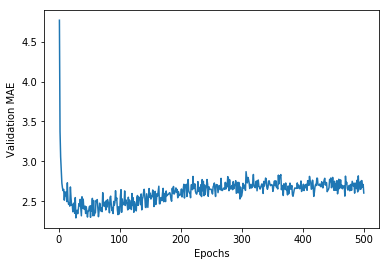

In [38]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

因为纵轴的范围较大，且数据方差相对较大，所以难以看清这张图的规律。我们来重新绘制一张图。

删除前 10 个数据点，因为它们的取值范围与曲线上的其他点不同。

将每个数据点替换为前面数据点的指数移动平均值，以得到光滑的曲线。

In [39]:
def smooth_curve(points,factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
smooth_mae_history = smooth_curve(average_mae_history[10:])

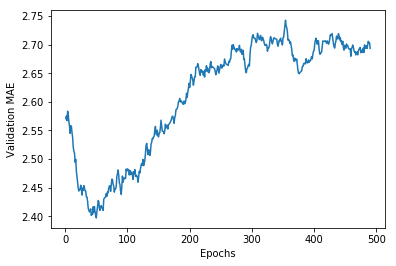

In [40]:
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

从上图可以看出，验证MAE 在80 轮后不再显著降低，之后就开始过拟合。

完成模型调参之后（除了轮数，还可以调节隐藏层大小），你可以使用最佳参数在所有训练数据上训练最终的生产模型，然后观察模型在测试集上的性能。

#### 训练最终模型

In [41]:
model = build_model()
model.fit(train_data,train_targets,epochs=80,batch_size=1,verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 895us/step


In [42]:
test_mae_score

2.630008613362032

你预测的房价还是和实际价格相差约2550 美元。

### 小结
回归问题使用的损失函数与分类问题不同。回归常用的损失函数是均方误差（MSE）。

 同样，回归问题使用的评估指标也与分类问题不同。显而易见，精度的概念不适用于回归问题。常见的回归指标是平均绝对误差（MAE）。

 如果输入数据的特征具有不同的取值范围，应该先进行预处理，对每个特征单独进行缩放。

 如果可用的数据很少，使用 K折验证可以可靠地评估模型。

 如果可用的训练数据很少，最好使用隐藏层较少（通常只有一到两个）的小型网络，以避免严重的过拟合。